In [ ]:
%load_ext autoreload
%autoreload 2

# Perspective transform to normalize the pixel image

In [ ]:
#export
from surfbreak import detection, graphutils, load_videos
from surfbreak import pipelines
import dask
import graphchain
import cv2

In [ ]:

flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph('../tmp/shirahama_1590387334_SURF-93cm.ts', n_samples=10)

with dask.config.set(num_workers=4):
    mean_flow, xrange, yrange = graphchain.get(flow_fit_graph, 'result', scheduler=dask.threaded.get)

print(mean_flow.shape)
print(xrange, yrange)

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
(1080, 1920, 2)
(0, 1631) (364, 570)


In [ ]:
graphutils.describe_graph(flow_fit_graph)

{'flow_tensor_0': "detection.avg_wave_flows(video_file='../tmp/shirahama_1590387334_SURF-93cm.ts', start_s=0, duration_s=1)",
 'flow_tensor_1': "detection.avg_wave_flows(video_file='../tmp/shirahama_1590387334_SURF-93cm.ts', start_s=120, duration_s=1)",
 'flow_tensor_2': "detection.avg_wave_flows(video_file='../tmp/shirahama_1590387334_SURF-93cm.ts', start_s=240, duration_s=1)",
 'flow_tensor_3': "detection.avg_wave_flows(video_file='../tmp/shirahama_1590387334_SURF-93cm.ts', start_s=360, duration_s=1)",
 'flow_tensor_4': "detection.avg_wave_flows(video_file='../tmp/shirahama_1590387334_SURF-93cm.ts', start_s=480, duration_s=1)",
 'flow_tensor_5': "detection.avg_wave_flows(video_file='../tmp/shirahama_1590387334_SURF-93cm.ts', start_s=600, duration_s=1)",
 'flow_tensor_6': "detection.avg_wave_flows(video_file='../tmp/shirahama_1590387334_SURF-93cm.ts', start_s=720, duration_s=1)",
 'flow_tensor_7': "detection.avg_wave_flows(video_file='../tmp/shirahama_1590387334_SURF-93cm.ts', start_s

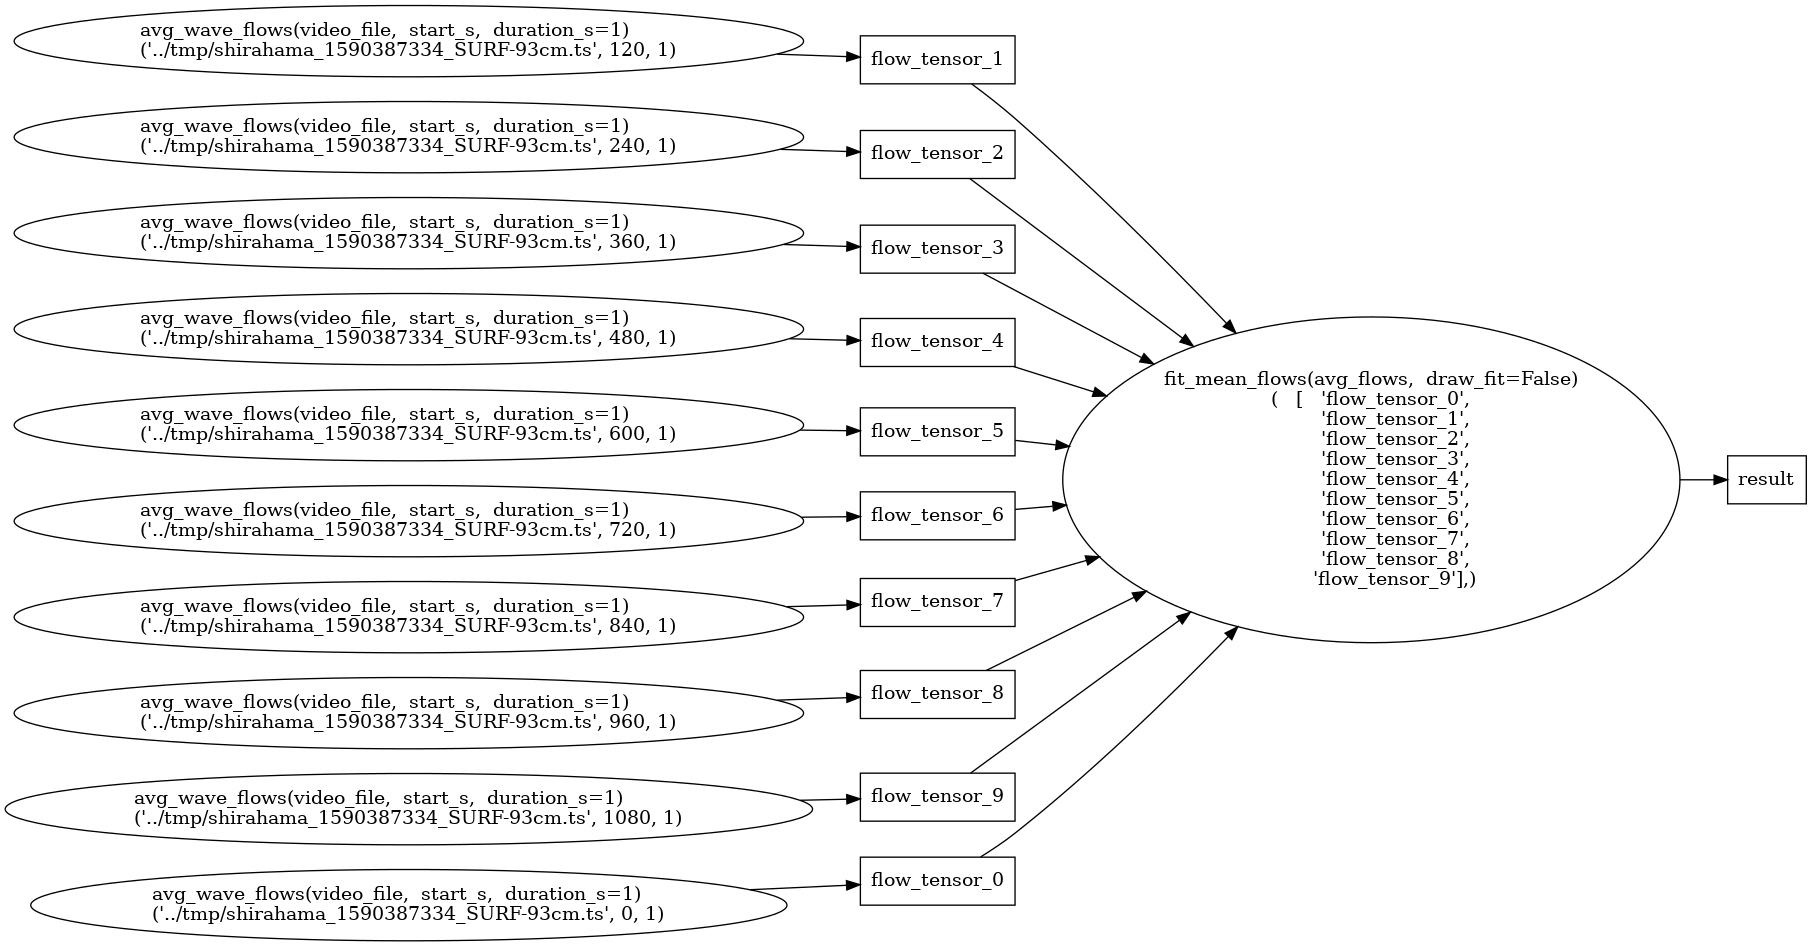

In [ ]:
graphutils.visualize(flow_fit_graph)

## Some key camera  assumption we can make: 
1. Ocean surface is flat (on average, over time)
1. Camera is definitely above wave surface looking down
1. Camera should have only yaw and pitch vs. horizon (approximately zero roll)

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt
from surfbreak.transform import normalized, shift_img, trim_image

## Crop and produce an averaged wave vector

In [ ]:
from surfbreak import load_videos
import cv2

video_file = '../tmp/shirahama_1590387334_SURF-93cm.ts'

frames = load_videos.decode_frame_sequence(video_file, duration_s=1, start_s=50, RGB=True,
                                              one_image_per_n_frames=2)

Decoding ../tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 


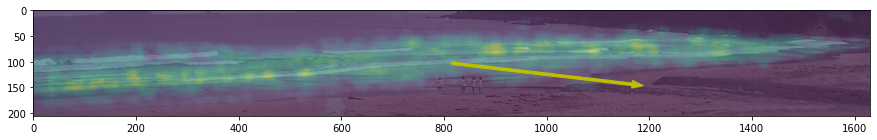

In [ ]:
wave_img = detection.trim_image(frames[0], xrange, yrange)


avg_wave_xdir = detection.trim_image(mean_flow[:,:,0], xrange, yrange).mean()
avg_wave_ydir = detection.trim_image(mean_flow[:,:,1], xrange, yrange).mean()
wave_vector = (avg_wave_xdir*2000, avg_wave_ydir*2000)

mean_flow_mag = np.sqrt(mean_flow[:,:,0]*mean_flow[:,:,0] + mean_flow[:,:,1]*mean_flow[:,:,1])

trimmed_mag = detection.trim_image(mean_flow_mag, xrange, yrange)
center = ((xrange[1] - xrange[0])//2, (yrange[1] - yrange[0])//2)

plt.figure(figsize=(15,5))
plt.imshow(wave_img)
plt.arrow(center[0], center[1], wave_vector[0], wave_vector[1], color='y', width=5)
plt.gca().imshow(trimmed_mag, alpha=0.4)

## Compute a homography matrix to center and scale the surfzone
Get a line fit to the surf zone, and calculate optical flow magnitude at the ends to find the two sets of 4 points that define a homography transform.

In [ ]:
from surfbreak.transform import fit_line, rotate_bound

array([[ 9.9911422e-01],
       [-4.2081323e-02],
       [ 7.8280597e+02],
       [ 9.6966553e+01]], dtype=float32)

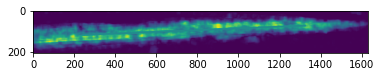

In [ ]:
import numpy as np
line, end_points = fit_line(trimmed_mag, plot=True)
line

### Calculate the homogrophy transform
https://docs.opencv.org/master/d9/dab/tutorial_homography.html

In [ ]:
from surfbreak.transform import flow_mag_at_point, fit_surfzone_homography_points

In [ ]:
for pct in [60,80,90,95]:
    leftmag = flow_mag_at_point(trimmed_mag, end_points[0], percentile=pct)
    rightmag = flow_mag_at_point(trimmed_mag, end_points[1], percentile=pct)
    print(pct, '\t',leftmag, '\t' ,rightmag)

60 	 0.6520079970359802 	 0.5911717772483825
80 	 0.740479052066803 	 0.67617746591568
90 	 0.8055878281593323 	 0.7274295508861542
95 	 0.8489329814910889 	 0.7571948736906051


Pre-transform homogrophy points:


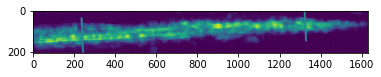

Post-transform homogrophy points:


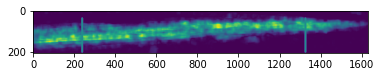

In [ ]:
pre_warp_corners, post_warp_corners = fit_surfzone_homography_points(trimmed_mag) 

img = cv2.line(trimmed_mag.copy(), tuple(pre_warp_corners[0]), tuple(pre_warp_corners[1]), .5, thickness=8)
img = cv2.line(img.copy(), tuple(pre_warp_corners[2]), tuple(pre_warp_corners[3]), .5, thickness=8)

img2 = cv2.line(trimmed_mag.copy(), tuple(post_warp_corners[0]), tuple(post_warp_corners[1]), .5, thickness=8)
img2 = cv2.line(img2.copy(), tuple(post_warp_corners[2]), tuple(post_warp_corners[3]), .5, thickness=8)

print("Pre-transform homogrophy points:")
plt.imshow(img)
plt.show()
print("Post-transform homogrophy points:")
plt.imshow(img2)
plt.show()

Homography matrix:
[[ 8.62775930e-01 -3.63387573e-02  3.23284980e+01]
 [ 3.07542059e-02  9.79089754e-01 -7.31819161e+00]
 [-8.73224595e-05  3.67842097e-06  1.00000000e+00]]

Transformed image:


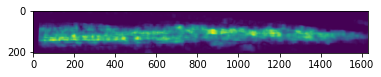

In [ ]:
H, _ = cv2.findHomography(pre_warp_corners, post_warp_corners)
print("Homography matrix:")
print(H)

mag_warped = cv2.warpPerspective(trimmed_mag, H, (trimmed_mag.shape[1], trimmed_mag.shape[0]))

print("\nTransformed image:")
plt.imshow(mag_warped)
plt.show()

### Compare images pre- and post- homography transform

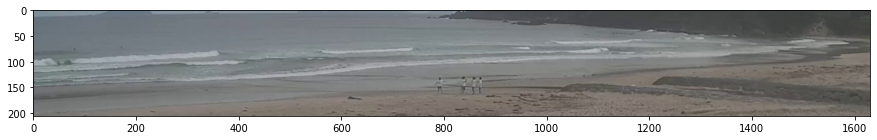

In [ ]:
# Image pre-transform
plt.figure(figsize=(15,5))
plt.imshow(wave_img)

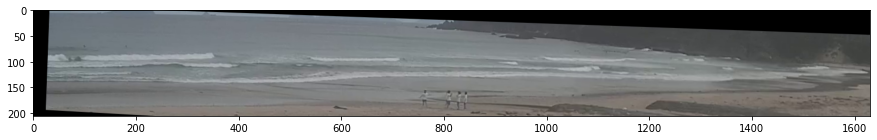

In [ ]:
# Image post-transform
img_warped = cv2.warpPerspective(wave_img, H, (wave_img.shape[1], wave_img.shape[0]))
plt.figure(figsize=(15,5))
plt.imshow(img_warped)

In [ ]:
from surfbreak.transform import pix_to_crop_from_dir, find_crop_range

(26, 1631) (38, 180)


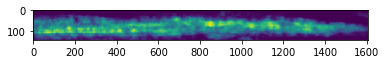

In [ ]:
cx_range, cy_range = find_crop_range(mag_warped)
print(cx_range, cy_range)

plt.imshow(mag_warped[cy_range[0]:cy_range[1],cx_range[0]:cx_range[1]])        

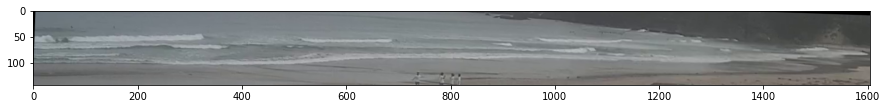

In [ ]:
img_warped = cv2.warpPerspective(wave_img, H, (wave_img.shape[1], wave_img.shape[0]))
plt.figure(figsize=(15,5))
plt.imshow(img_warped[cy_range[0]:cy_range[1],cx_range[0]:cx_range[1]])  

## Now, gather into a convenient function

What we'll need to convert each raw image in the videos

1. Pre-transform surfzone xrange and yrange (Done)  
1. Homography matrix
1. Post-transform xrange and yrange
1. Pipeline to calculate the above across several videos

In [ ]:
from surfbreak import detection, graphutils
from surfbreak import pipelines
import dask
import graphchain

flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph('../tmp/shirahama_1590387334_SURF-93cm.ts', n_samples=10)

with dask.config.set(num_workers=4):
    mean_flow, rx_range, ry_range = graphchain.get(flow_fit_graph, 'result', scheduler=dask.threaded.get)

print("\n#1: Rough surfzone xrange and yrange:")
print(rx_range, ry_range)

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]

#1: Rough surfzone xrange and yrange:
(0, 1631) (364, 570)


In [ ]:
from surfbreak.transform import (image_flow_magnitude, fit_homography_to_mean_flow, warp_trimmed_image, 
                                find_surfspot_calibration_params, normalize_image, plot_mean_flow_mag)

In [ ]:
H = fit_homography_to_mean_flow(mean_flow, rx_range, ry_range)
print("#2: Homography matrix:")
print(H)

#2: Homography matrix:
[[ 8.62775930e-01 -3.63387573e-02  3.23284980e+01]
 [ 3.07542059e-02  9.79089754e-01 -7.31819161e+00]
 [-8.73224595e-05  3.67842097e-06  1.00000000e+00]]


In [ ]:
mean_flow_mag = image_flow_magnitude(mean_flow)
trimmed_mag = detection.trim_image(mean_flow_mag, rx_range, ry_range)
mag_warped = warp_trimmed_image(trimmed_mag, H)
tx_range, ty_range = find_crop_range(mag_warped)
print("#3: Post-transform xrange and yrange:")
print(tx_range, ty_range)

#3: Post-transform xrange and yrange:
(26, 1631) (38, 180)


In [ ]:
print("#2 (Homography matrix H), and #3 (post-transform xrange and yrange):")
find_surfspot_calibration_params(mean_flow, rx_range, ry_range)

#2 (Homography matrix H), and #3 (post-transform xrange and yrange):


{'crop_xrange': (0, 1631),
 'crop_yrange': (364, 570),
 'h_matrix': array([[ 8.62775930e-01, -3.63387573e-02,  3.23284980e+01],
        [ 3.07542059e-02,  9.79089754e-01, -7.31819161e+00],
        [-8.73224595e-05,  3.67842097e-06,  1.00000000e+00]]),
 'warped_xrange': (26, 1631),
 'warped_yrange': (38, 180)}

### Now accumulate across many videos

In [ ]:
calibration_videos = [
    '../data/shirahama_1590387334_SURF-93cm.ts',
    '../data/shirahama_1590312313_SURF-101cm.ts',
    '../data/shirahama_1592790996_SURF-129cm.ts',
    '../data/shirahama_1590479277_SURF-59cm.ts',
    '../data/shirahama_1590378088_SURF-93cm.ts'
]

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]


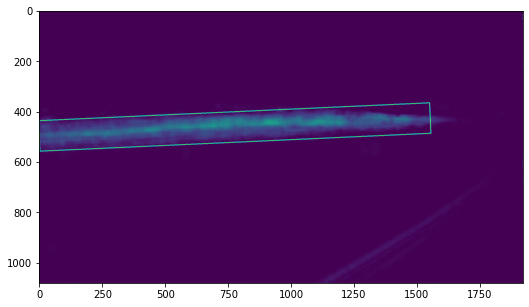

{'crop_xrange': (0, 1554),
 'crop_yrange': (364, 556),
 'h_matrix': array([[ 6.62036364e-01, -2.76042952e-02,  6.92719927e+01],
        [ 1.32273999e-02,  9.49345826e-01, -3.07592747e+00],
        [-2.26051225e-04,  9.42380515e-06,  1.00000000e+00]]),
 'warped_xrange': (64, 1554),
 'warped_yrange': (33, 178)}

In [ ]:
video_mean_flows = []
for vid in calibration_videos:
    flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph(vid, n_samples=10, duration_s=2)

    with dask.config.set(num_workers=3):
        meanflow, xyrange, yrange = graphchain.get(flow_fit_graph, 'result', scheduler=dask.threaded.get)
    video_mean_flows.append(meanflow)

# Ignore the fit ranges from the individual videos, and re-fit across videos
acc_mean_flow, acc_xrange, acc_yrange = detection.fit_mean_flows(video_mean_flows, draw_fit=True)

calibration_parameters = find_surfspot_calibration_params(acc_mean_flow, acc_xrange, acc_yrange)
calibration_parameters

Flow magnitude of the video tensors:


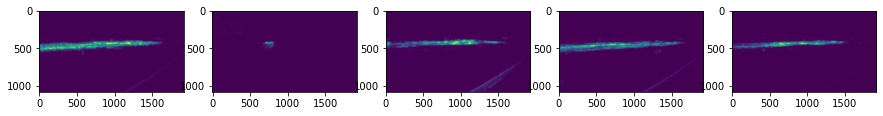

Flow magnitude of the accumulated tensor:
x range:  (0, 1554)   y range:  (364, 556)


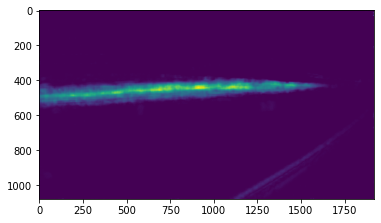

In [ ]:
fig, axes = plt.subplots(ncols=len(video_mean_flows), figsize=(15,5))
for idx, mf in enumerate(video_mean_flows):
    plot_mean_flow_mag(mf, axis=axes[idx])
print("Flow magnitude of the video tensors:")
plt.show()

plot_mean_flow_mag(acc_mean_flow)
print("Flow magnitude of the accumulated tensor:")
print("x range: ", acc_xrange, "  y range: ", acc_yrange)
plt.show()

## Demonstration of using the surfspot normalization parameters
to transform a sequence of images from one video into the static surfspot view

In [ ]:
from surfbreak.transform import run_surfcam_calibration, video_file_to_calibrated_image_tensors    

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]


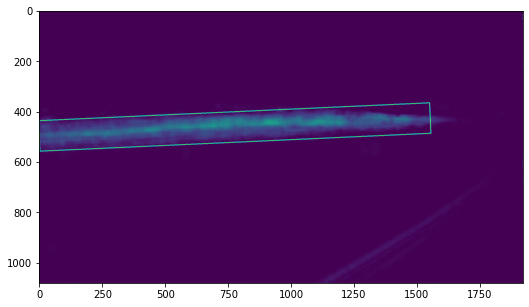

Decoding ../tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 


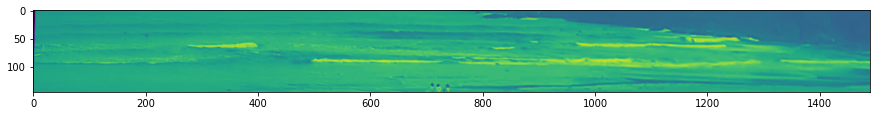

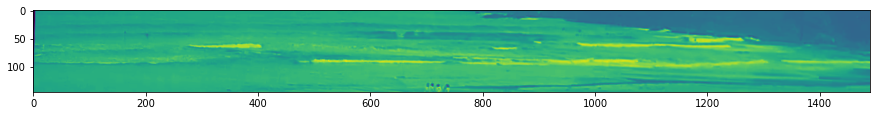

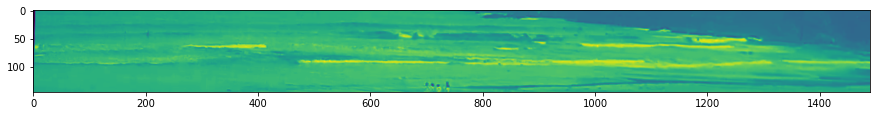

In [ ]:
calibration_params = run_surfcam_calibration(calibration_videos)

video_file = '../tmp/shirahama_1590387334_SURF-93cm.ts'
image_tensor = video_file_to_calibrated_image_tensors(video_file, calibration_params, duration_s=1, start_s=0)
for frame_idx in range(3):
    plt.figure(figsize=(15,5))
    plt.imshow(image_tensor[:,:,frame_idx*3])
    plt.show()

Decoding ../data/shirahama_1592790996_SURF-129cm.ts  Duration: 20.0m (1200.03s)  FPS: 60.0  Emitting 1/6 of frames 


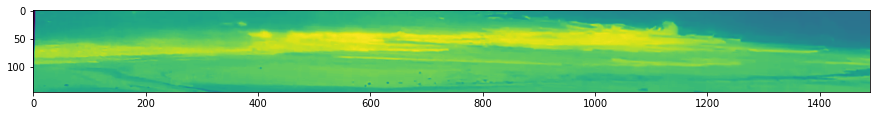

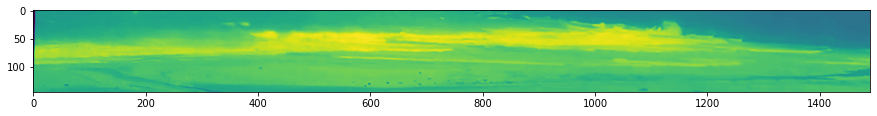

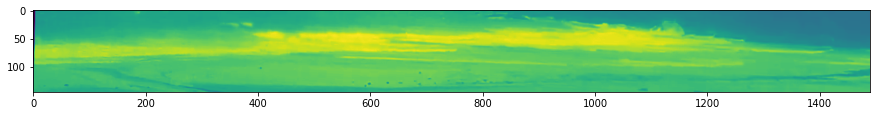

In [ ]:
video_file = '../data/shirahama_1592790996_SURF-129cm.ts'
image_tensor = video_file_to_calibrated_image_tensors(video_file, calibration_params, duration_s=1, start_s=0)
for frame_idx in range(3):
    plt.figure(figsize=(15,5))
    plt.imshow(image_tensor[:,:,frame_idx*3])
    plt.show()

# Generate calibrated image tensors from video using cached computation graphs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


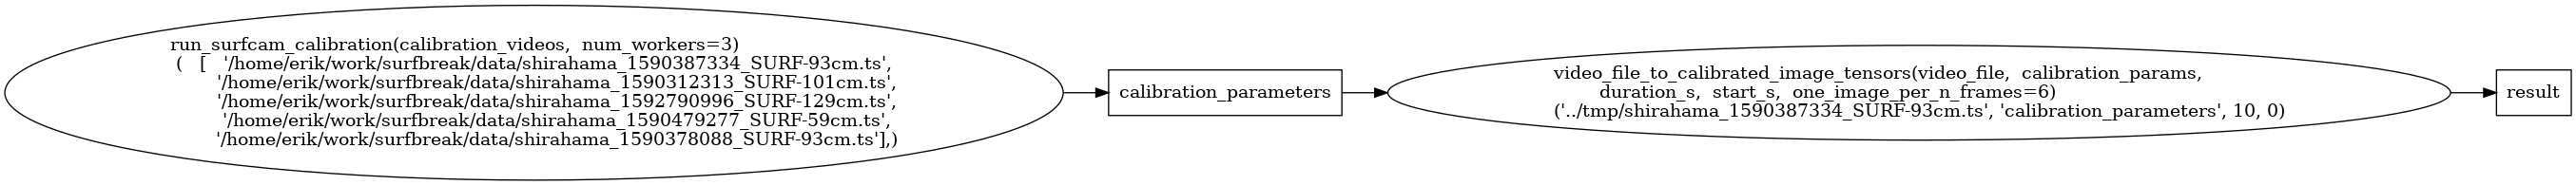

In [ ]:
%load_ext autoreload
%autoreload 2
from surfbreak import graphutils
from surfbreak import pipelines
import graphchain
import dask
import matplotlib.pyplot as plt

# These tensors are 10hz by default (1/6th of the frames from a of 60Hz video)
img_tensor_graph = pipelines.video_to_calibrated_image_tensor('../tmp/shirahama_1590387334_SURF-93cm.ts',
                                                                duration_s=10, start_s=0)
graphutils.visualize(img_tensor_graph)

(145, 1490, 100)


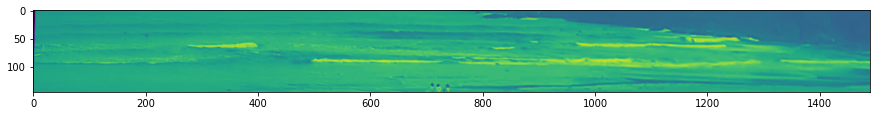

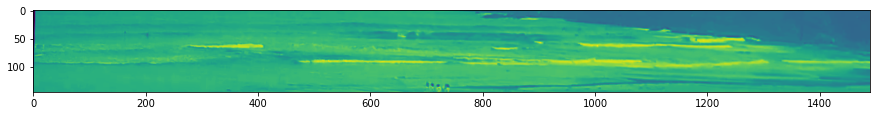

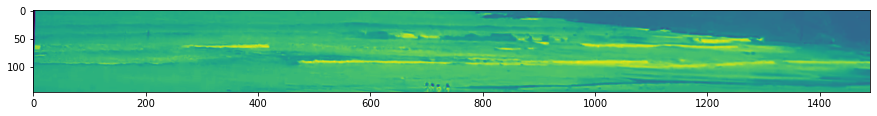

In [ ]:
img_tensor = graphchain.get(img_tensor_graph, 'result')
print(img_tensor.shape)
for frame_idx in range(3):
    plt.figure(figsize=(15,5))
    plt.imshow(img_tensor[:,:,frame_idx*4])
    plt.show()